# Итоговая аттестация. Часть 2


## Задача 1

Подведите результаты эксперимента в экселе по следующим данным: ab_stats.csv
Стат значимо ли отличается ARPPU в двух группах ? Какие рекомендации дадите менеджеру?

_Примечание. ARPPU — это доход на одного платящего пользователя._

In [1]:
import pandas as pd

data = pd.read_csv('ab_stats.csv')
data.head()

,revenue,num_purchases,purchase,ab_group,av_site visit
0,0.0,0,0,A,9.040174
1,0.0,0,0,A,4.811628
2,0.0,0,0,A,7.342623
3,0.0,0,0,A,7.744581
4,0.0,0,0,A,10.511814


In [2]:
# Рассчитываем ARPPU для каждой группы, отделяя только заплативших пользователей

users_A = data[(data['ab_group'] == 'A') & (data['num_purchases'] > 0)]
users_B = data[(data['ab_group'] == 'B') & (data['num_purchases'] > 0)]

# Доход по группам
revenue_result_A = users_A['revenue'].sum()
revenue_result_B = users_B['revenue'].sum()

# Кол-во пользователей
count_users_A = len(users_A)
count_users_B = len(users_B)

# Рассчитываем ARPPU по формуле
ARPPU_A = revenue_result_A / count_users_A if count_users_A > 0 else 0
ARPPU_B = revenue_result_B / count_users_B if count_users_B > 0 else 0

ARPPU_A, ARPPU_B

(18.698468640625, 12.36211875641025)

ARPPU для группы A - 18.70, для группы B - 12.36 при округлении.

Применим U-тест Манна-Уитни чтобы сравнить медианы двух групп и определить, есть ли статистически значимые различия между ними.

In [3]:
from scipy.stats import mannwhitneyu

# Perform Mann-Whitney U test
stat, p_value = mannwhitneyu(users_A['revenue'], users_B['revenue'], alternative='two-sided')

p_value

0.8871956616344514

P-значение, полученное в результате теста, составляет примерно 0.89 при принятом среднем значении 0.05. Это значит, что мы не можем отклонить гипотезу о том, что распределения доходов в группах A и B не отличаются.
Можем сделать вывод, что отличия не являются статистически значимыми.

Рекомендации менеджеру:
1. Выбрать дополнительные метрики и исследования для принятия решений.
2. Не принимать решений только на основании текущего теста, т.к. результаты не оказались статистически важными.


## Задание 2


Мы хотим провести А/Б-тест для трех источников трафика. Нынешняя конверсия равна 5%, мы ожидаем прирост в 0,2%.
Уровень доверия 97% и уровень мощности 87%. Всего на наш продукт заходит 40 000 пользователей в месяц.

* Задание 2.1: За сколько дней мы сможем протестировать гипотезу? И что вы можете посоветовать по
результатам подсчета?
* Задание 2.2: Допустим в задаче нет проблемы с количеством посетителей на сайт, тогда подведите
результаты тестирования, если у нас следующие результаты по количеству конверсии:
1) 25 000
2) 30 000
3) 32 000


### Задание 2.1
Для решения используем формулу для расчета размера выборки на каждую группу:

$$
n = \left( \frac{{Z_{\alpha/2} \cdot \sqrt{{2 \cdot p \cdot (1 - p)}} + Z_{\beta} \cdot \sqrt{{p_1 \cdot (1 - p_1) + p_2 \cdot (1 - p_2)}}}}{{p_2 - p_1}} \right)^2
$$

где:

- $n$ — размер выборки на каждую группу,
- $Z_{\alpha/2}$ — уровень доверия,
- $Z_{\beta}$ — мощность теста,
- $p$ — базовая конверсия,
- $p_1$ — старая конверсия (равна $p$),
- $p_2$ — новая конверсия (равна $p + \Delta p$), где $\Delta p$ — ожидаемое изменение конверсии.

 $\alpha = 1 - 0.97 = 0.03$ и $Z_{\alpha/2}$ равен z-значению, соответствующему вероятности $1 - \alpha/2 = 0.985$.

$Z_{\beta}$ равен z-значению $0.87$.

$p = 0.05$, $\Delta p = 0.002$, $p_1 = 0.05$ и $p_2 = 0.052$.

С учетом трех источников трафика итоговый результат умножаем на 3.

In [4]:
import math
import scipy.stats as stats

# Определяем основные переменные для расчета формулы
alpha = 0.03
Z_alpha = stats.norm.ppf(1 - alpha / 2)
power = 0.87
Z_beta = stats.norm.ppf(power)
p = 0.05
delta_p = 0.002
p1 = p
p2 = p + delta_p

# Подсавляем значения в формулу
n_group = (Z_alpha * math.sqrt(2 * p * (1 - p)) + Z_beta * math.sqrt(p1 * (1 - p1) + p2 * (1 - p2)))**2 / (p2 - p1)**2
# Общий размер выборки умножаем на 3, т.к. у нас 3 источника
n_total = 3 * n_group

# Кол-во пользователей в месяц
users_per_month = 40000
days = n_total / users_per_month * 30

days

584.4337327495709

В результате мы получили, что потребуется более 584 дней для поверки гипотезы, это слишком долго (значительно больше месяца).
Я советую пересмотреть данные для проведения или выбрать другой способ исследования.

### Задание 2.2

In [5]:
# Результаты тестирования для заданных значений конверсии
conversions = [25000, 30000, 32000]
test_results = []

for conversion in conversions:
    # Успешные попытки в группах
    success_control = round(n_group * p1)
    success_test = conversion

    # Провальные попытки в группах
    failure_control = n_group - success_control
    failure_test = n_group - success_test

    # Общее количество попыток
    success_total = success_control + success_test
    failure_total = failure_control + failure_test

    total = 2 * n_group

    # Ожидаемый процент
    prop_control = success_total / total
    prop_test = success_test / n_group

    # Z-статистика
    z = (prop_test - prop_control) / math.sqrt(prop_control * (1 - prop_control) * (1 / n_group + 1 / n_group))
    p_value = 1 - stats.norm.cdf(z)

    # Результат теста
    reject_null = p_value < alpha
    test_results.append((z, p_value, reject_null))

test_results

[(32.010529716729984, 0.0, True),
 (42.83885586070758, 0.0, True),
 (46.897099934237474, 0.0, True)]

Конверсии не равны, т.к. z-статистика по результатам превышает критическое значение. Новая конверсия значительно отличается от старой. 

## Задание 3


Вы решили сравнивать метрику CPA в двух группах. Размер выборки - 2350 элементов в каждой группе.
Для проверки нормальности распределения на выборке в 2350 наблюдений применили критерий Шапиро-Уилка и получили p-value, равный 0.00002, alpha = 5%.

Какой бы вывод мы могли сделать в данном случае?

В этом случае какой статистический критерий для проверки первоначальной гипотезы тут лучше всего подойдёт и почему?

### Ответ

При применении критерия  Шапиро-Уилка если p-value меньше уровня значимости (alpha), то нулевая гипотеза о том, что данные подчиняются нормальному распределению, отвергается. Исходя из представленых значений мы отклоняем гипотезу о нормальном распределении. (0,00002 < 0,05).


Можно взять критерий Манна-Уитни. Он может быть использован для независимых выборок. Для неравномерно распределенных данных этот критерий подходит лучше остальных.

## Задание 4

Мы провели АБ-тест на увеличение average timespent per user. По итогам тестирования мы получили следующие данные. Является ли результат статистически значимым с уровнем
доверия 80%? Какую версию мы выкатим на продакшн?

A. Средняя - 360, отклонение - 40, количество - 9802

B. Средняя - 352, отклонение - 58, количество - 9789

## Ответ

Предположим, что данные распределены нормально и применим t-тест.

In [6]:
mean_A = 360
std_dev_A = 40
num_A = 9802
mean_B = 352
std_dev_B = 58
num_B = 9789

# Расчет средней ошибки
std_error = math.sqrt(std_dev_A**2 / num_A + std_dev_B**2 / num_B)

# t-статистика
t_statistic = (mean_A - mean_B) / std_error

# Cтепень свободы
df = num_A + num_B - 2

#  p-значения
p_value = (1 - stats.t.cdf(abs(t_statistic), df)) * 2

reject_null = p_value < alpha
t_statistic, p_value, reject_null

(11.236630785707332, 0.0, True)

Результат опровернвет гипотезу о равенстве средних значений.
t-статистика равна 11.24, соответствующее p-значение равно 0, а это меньше уровня значимости $\alpha = 0.2$. поэтому мы отвергаем нулевую гипотезу о равенстве средних. 
Различия в среднем времени пользователя статистически значимые.

Т.к. значения статистически значимы, на прод отправим вариант А с большим значением.

## Задание 5

Создайте техническую архитектуру проекта по аб тестированию продукта он-лайн кинотеатра
с учетом кросс-девайс аналитики по следующей гипотезе:

Если договориться с банком о 99% кэшбэке на подписку первого месяца, то это повысит
конверсию в подписку на 30%, благодаря упрощенному принятию решения со стороны
пользователя.

На схеме необходимо отобразить:
1. Управленческий процесс по договоренностям с внешними партнерами
2. Архитектуру данных с указанием систем, из которых будем скачивать данные
3. Внутрикомандное взаимодействие

## Ответ

1. **Управленческий процесс по договоренностям с внешними партнерами**

    1. Отдел по работе с партнерами заключает договор с банком.
    2. Когда договор подписан, отдел по работе с партнерами передает информацию в продуктовую команду для разработки и внедреия соответствующего функционала.
    3. Продуктовая команда готовит решение с кешбеком на первый месяц подписки.
    4. Отдел по работе с партнерами внедряет решение.
    5. (Опционально) Отдел маркетинга готовит материалы для продвижения нового решения.(на схеме не указано)

![Договор с банком.drawio.png](<attachment:Договор с банком.drawio.png>)

2. **Архитектура данных с указанием систем, из которых будем скачивать данные**

   - Система управления подписками
   - Система мониторинга
   - Система управления данными
   - Система сбора аналитики

3. **Внутрикомандное взаимодействие**

   - Отдел по работе с партнерами - выстраивает взаимоотношения и заключат договора с внешним партнера, включая банки. Передает информацию в продуктовую команду.
   - Команда управления продуктом - анализирует запросы и предлагает возможные решения. Передает решения в разработку. Также по готовности информирует маркетинг.
   - Команда разработки - реализует/настраивает функциональность. Информиует о готовности продуктовую команду.
   - Отдел маркетинга - готовит материалы для продвижения. Информирует продуктовую команду.


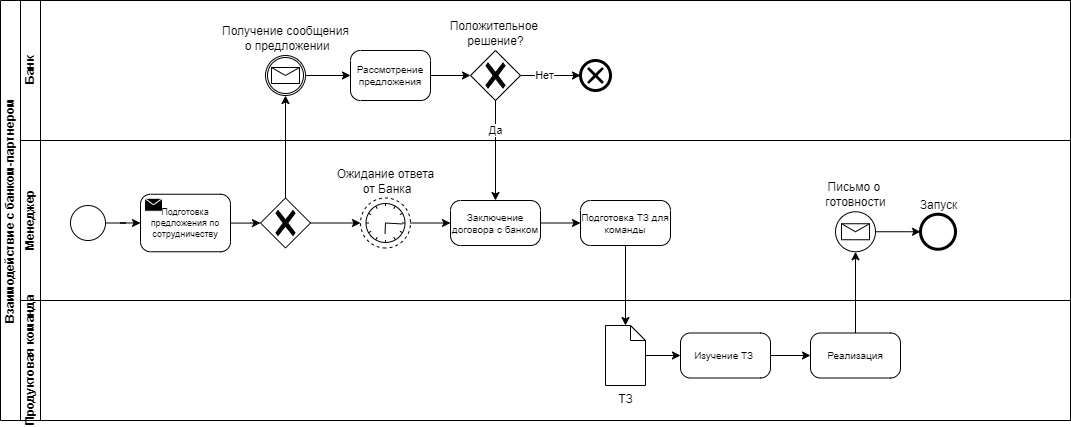